## Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

In [1]:
import os
import time

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from IPython.display import clear_output
from tensorflow_examples.tensorflow_examples.models.pix2pix import pix2pix

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info = True, as_supervised = True)

train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']

In [5]:
# Params

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size = [IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
# Setup input pipeline

train_monet = train_monet.map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_photo = train_photo.map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls = AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [12]:
sample_monet = next(iter(train_monet))
sample_photo = next(iter(train_photo))

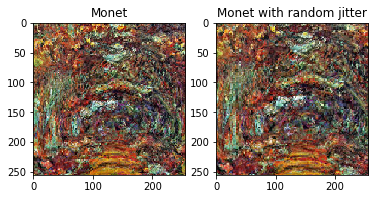

In [13]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

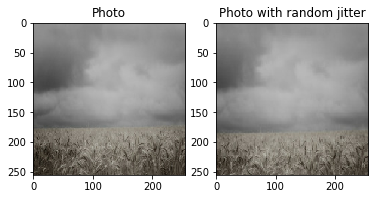

In [14]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

The model architecture here is very similar to what was used in pix2pix. Some of the differences are:

Cyclegan uses instance normalization instead of batch normalization.
The CycleGAN paper uses a modified resnet based generator. This uses a modified unet generator for simplicity.
There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

- Generator G learns to transform image X to image Y. 
- Generator F learns to transform image Y to image X. 
- Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
- Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')

discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm', target = False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm', target = False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 2 524800      sequential_1[0][0]               
______________________________________________________________________________________________

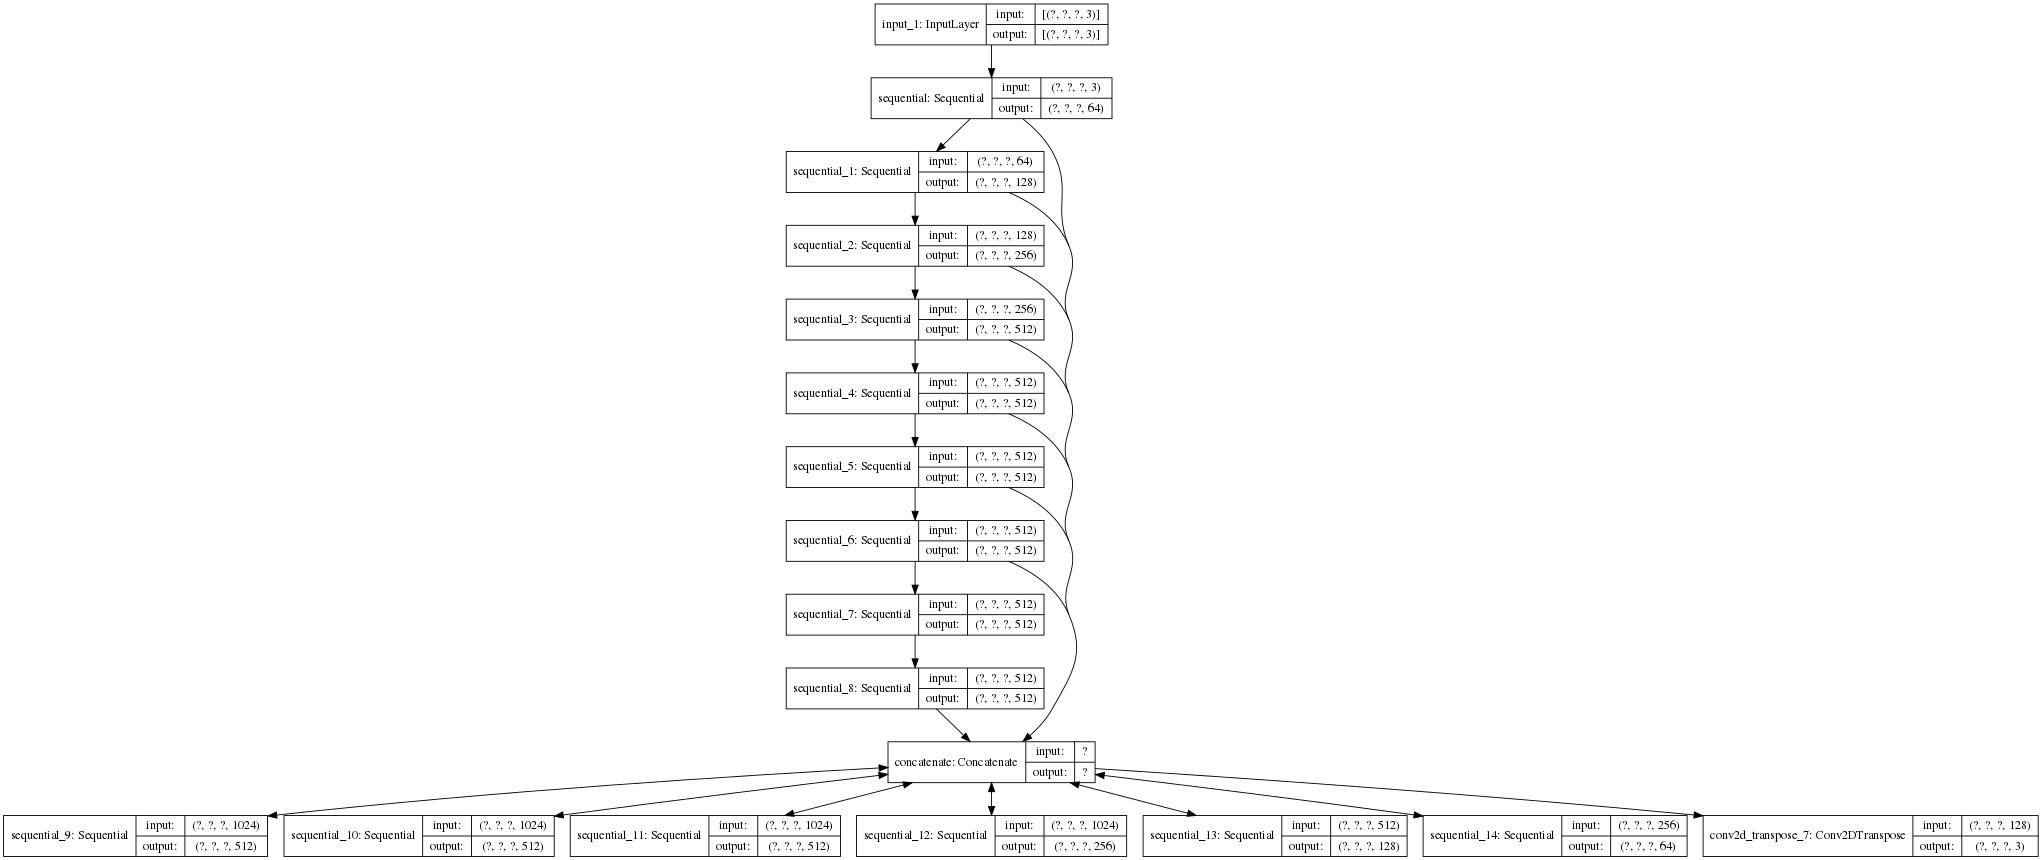

In [16]:
# Get Generator details
generator_g.summary()
tf.keras.utils.plot_model(generator_g, show_shapes = True, dpi = 64)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_33 (Sequential)   (None, None, None, 64)    3072      
_________________________________________________________________
sequential_34 (Sequential)   (None, None, None, 128)   131328    
_________________________________________________________________
sequential_35 (Sequential)   (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, None, None, 256)   0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_33 (I (None, None, None, 512)   1024

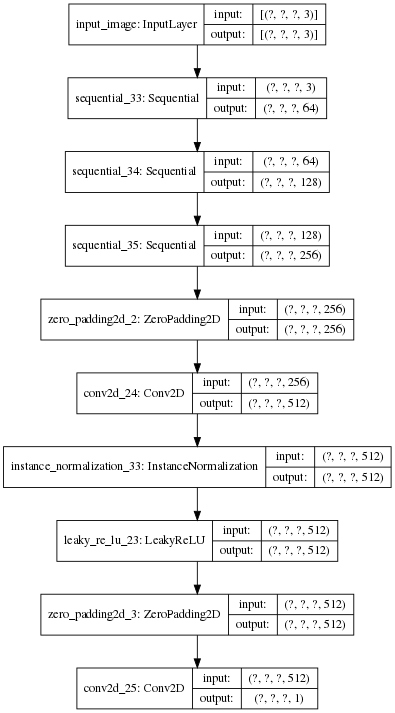

In [17]:
# Get Discriminator details
discriminator_y.summary()
tf.keras.utils.plot_model(discriminator_y, show_shapes = True, dpi = 64)

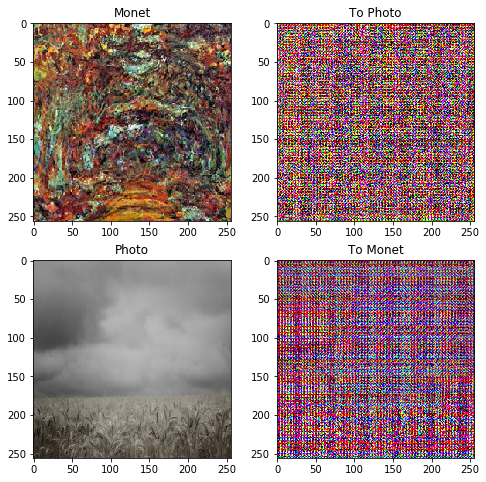

In [18]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
plt.figure(figsize = (8, 8))
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['Monet', 'To Photo', 'Photo', 'To Monet']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

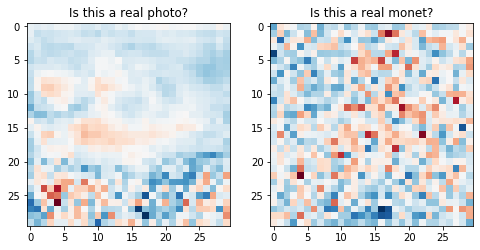

In [19]:
plt.figure(figsize = (8, 8))

plt.subplot(121)
plt.title('Is this a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(122)
plt.title('Is this a real monet?')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

## Loss Functions

In [20]:
LAMBDA = 10

In [21]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [22]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [23]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In cycle consistency loss,
Image  is passed via generator  that yields generated image.
Generated image is passed via generator that yields cycled image.

In [24]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator  is responsible for translating image  to image . Identity loss says that, if you fed image  to generator , it should yield the real image  or something close to image .

In [25]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

### Setup optimizers and checkpoints

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g = generator_g,
                           generator_f = generator_f,
                           discriminator_x = discriminator_x,
                           discriminator_y = discriminator_y,
                           generator_g_optimizer = generator_g_optimizer,
                           generator_f_optimizer = generator_f_optimizer,
                           discriminator_x_optimizer = discriminator_x_optimizer,
                           discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


### Training

In [28]:
EPOCHS = 1

In [29]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize = (12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

- Get the predictions.
- Calculate the loss.
- Calculate the gradients using backpropagation.
- Apply the gradients to the optimizer.

In [30]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent = True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training = True)
    cycled_x = generator_f(fake_y, training = True)

    fake_x = generator_f(real_y, training = True)
    cycled_y = generator_g(fake_x, training = True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training = True)
    same_y = generator_g(real_y, training = True)

    disc_real_x = discriminator_x(real_x, training = True)
    disc_real_y = discriminator_y(real_y, training = True)

    disc_fake_x = discriminator_x(fake_x, training = True)
    disc_fake_y = discriminator_y(fake_y, training = True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

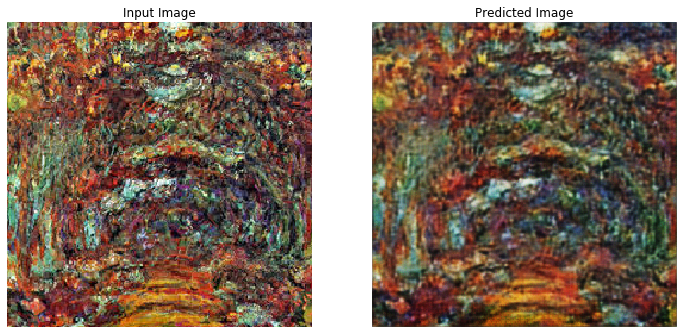

Time taken for epoch 1 is 3615.5387728214264 sec



In [31]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_monet, train_photo)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end = '')
    n+=1

  clear_output(wait = True)

  generate_images(generator_g, sample_monet)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

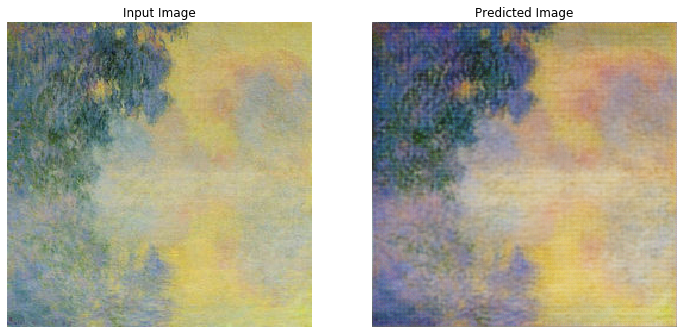

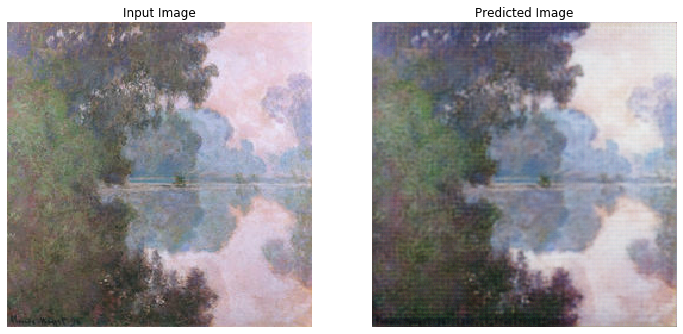

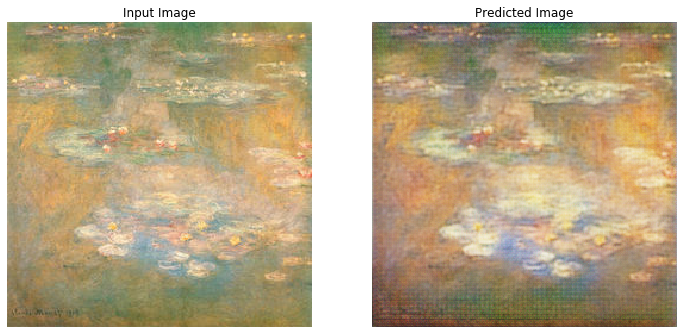

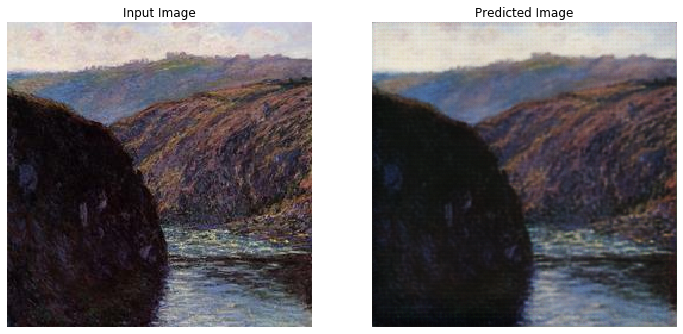

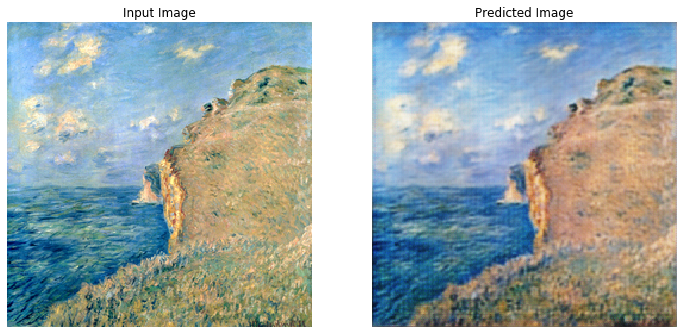

In [32]:
# Run the trained model on the test dataset
for inp in test_monet.take(5):
  generate_images(generator_g, inp)